# Lab assignment №2: Gradient boosting and feature importance estimation

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

There are several great frameworks (listed below). However, we recommend to stick to `LightGBM` for this task.
* LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). It is one of the most popular frameworks these days that shows both great quality and performance.
* xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
* Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features.

Some simple preprocessing is done for you. 

Parts 1 and 3 have the same weight equal to $1$. Part 2 has weight $0.5$.

### Part 1:
Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset:

* $\geq 90\%$ accuracy: 0.5 points for this part
* $\geq 92\%$ accuracy: 0.7 points for this part
* $\geq 94\%$ accuracy: 1 point for this part

In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

In [2]:
X_train = np.genfromtxt('data/train/X_train.txt')
y_train = np.genfromtxt('data/train/y_train.txt')

X_test = np.genfromtxt('data/test/X_test.txt')
y_test = np.genfromtxt('data/test/y_test.txt')

with open('data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [3]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [4]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [5]:
try: 
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/ml-mipt/ml-mipt/basic_s20/homeworks_basic/Lab2_boosting/unique_columns.txt -nc
    unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)

X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [6]:
pca = PCA(0.99)

In [7]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [8]:
X_train_pca.shape

(7352, 179)

In [9]:
X_test_pca.shape

(2947, 179)

Text(0, 0.5, 'Principal component 2')

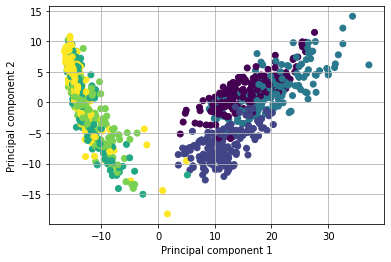

In [10]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0, 0.5, 'Principal component 5')

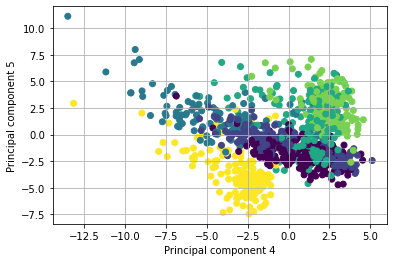

In [11]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

Please try at least several models of different structure.

Provide the following to describe your path:

* Plot describing the model accuracy/precision/recall w.r.t. model complexity.
* ROC-AUC plot for the 3 best models you aquired (for multiclass case you might refer to the `scikit-plot` library.
* Small report describing your experiments.

[DART](https://arxiv.org/abs/1505.01866) might be useful as well in your experiments. It is available in [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html) and [LightGBM](https://lightgbm.readthedocs.io/en/latest/Parameters.html), but seems [missing in CatBoost](https://github.com/catboost/catboost/issues/1006).

__Without the report and plots maximum score for this part of the lab is 0.3 of its full weight.__

In [17]:
from sklearn.metrics import accuracy_score
import scikitplot as skplt
import lightgbm
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

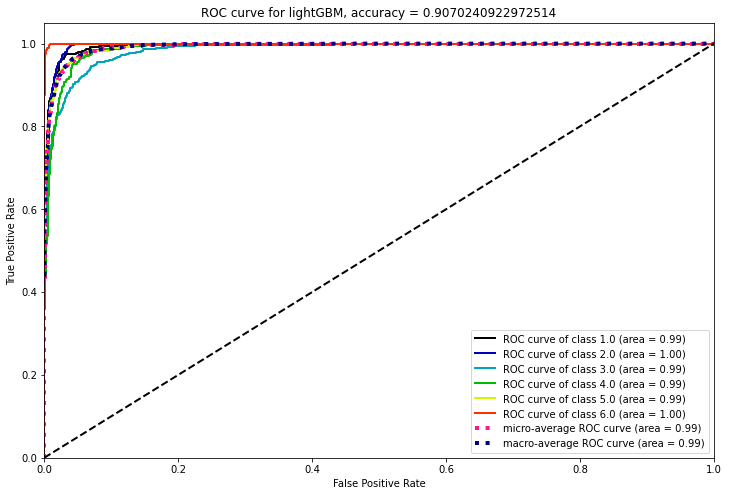

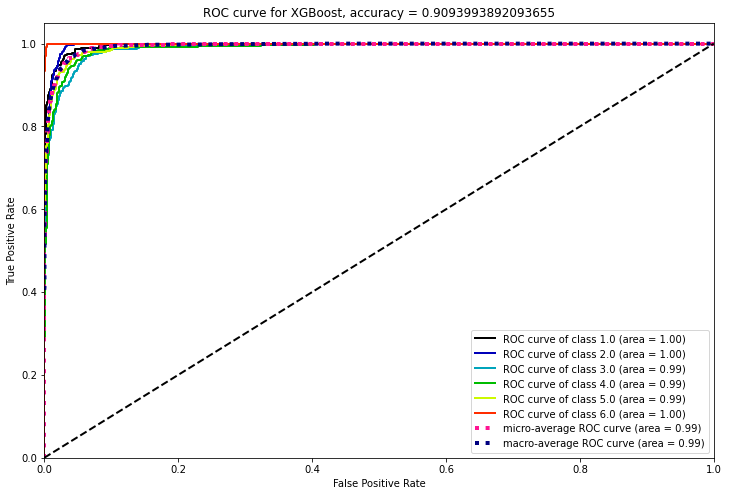

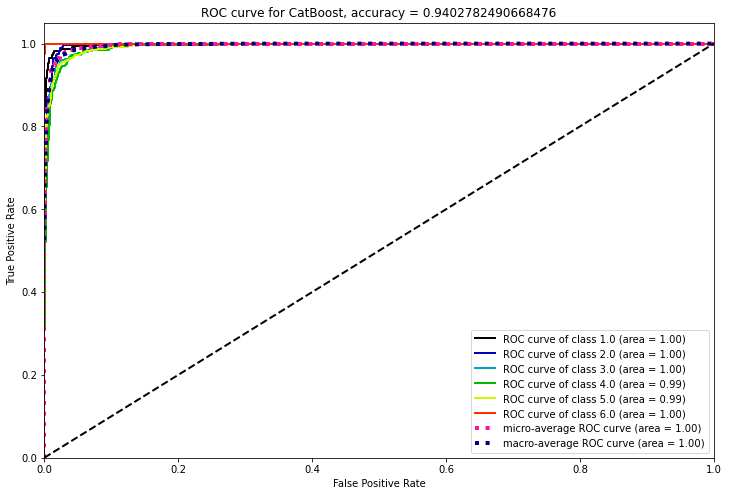

In [72]:
for name, clf in zip(['lightGBM', 'XGBoost', 'CatBoost'], [LGBMClassifier(), XGBClassifier(), CatBoostClassifier()]):
    clf.fit(X_train_pca, y_train, verbose=0)
    accuracy = accuracy_score(y_test, clf.predict(X_test_pca))
    title = 'ROC curve for {}, accuracy = {}'.format(name, accuracy)
    y_probas = clf.predict_proba(X_test_pca)
    skplt.metrics.plot_roc(y_test, y_probas, title=title, figsize=(12, 8))

Я пробовал подбирать оптимальные параметры для lightgbm с помощью GridSearchCv, но точность выше 91.0 получить не удалось.
Lightgbm от xgboost по точности не сильно отличается, но у lightgbm сильнее разброс по точности классификации разных классов - это видно по графику ROC AUC. CatBoost работает достаточно долго, но, как и обещают у них на сайте, даже без дополнительных параметров дает классную точность - больше 94.

**вывод:**
Яндекс красавцы!

### Part 2. Blending the models

Take three (or more) best models and try to build the blending ensemble of them. Compare the quality of the final model using the same quality measures as above.

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

In [15]:
base_models = [
    LGBMClassifier(), 
    LGBMClassifier(boosting_type='dart'),
    LGBMClassifier(boosting_type='goss'),
    XGBClassifier()
]

for model in base_models:
    model.fit(X_train_pca, y_train)

In [155]:
df_train = pd.DataFrame(X_train_pca)
df_test = pd.DataFrame(X_test_pca)
y_train_df = pd.DataFrame(y_train)

for model in base_models:
    y_pred = model.predict(X_test_pca)
    
    print(accuracy_score(y_test, y_pred))
    
    y_pred_df = pd.DataFrame(y_pred)
    df_train = pd.concat([df_train, y_train_df], axis=1)
    df_test = pd.concat([df_test, y_pred_df], axis=1)

0.9070240922972514
0.8873430607397353
0.9131319986426875
0.9093993892093655


In [156]:
model = LogisticRegression()
model.fit(df_train,y_train)
accuracy_score(y_test, model.predict(df_test))

0.9392602646759416

**Вывод:** с помощью блендинга из нескольких моделей, имеющих не очень высокую точность по отдельности (около 90), можно получить оценку с точностью близкой к CatBoost, а лучше CatBoost, как мы уже знаем, ничего в мире нет.

### Part 3. Explaining the model and estimating the feature importances.

Now your goal to take three best models and estimate feature importances using this models.

* First, use the methods that libraries provide by default (e.g. `lightgbm.plot_importance`).
* Next, use the [`shap`](https://github.com/slundberg/shap) library to explain the models behaviour and analyse the model performance. Compare the feature importances estimated by `shap` and by methods on the previous step.

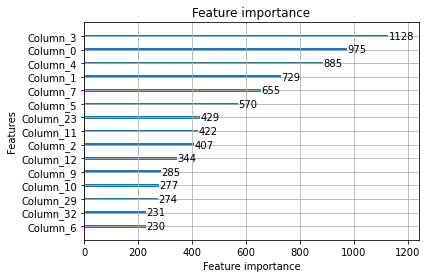

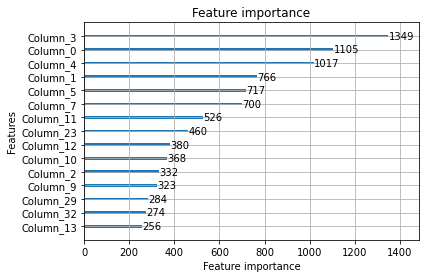

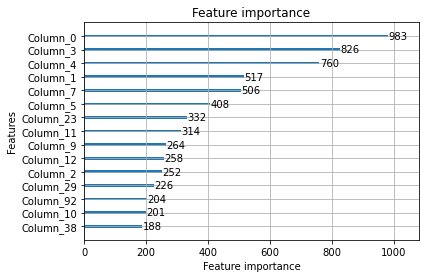

In [18]:
# используем уже обученные lightgbm модели и посмотрим, какие фичи самые важные
for model in base_models[:-1]:
    lightgbm.plot_importance(model, max_num_features=15)

In [68]:
import shap

In [37]:
shap.initjs()

In [38]:
model = base_models[0]

In [39]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_pca)

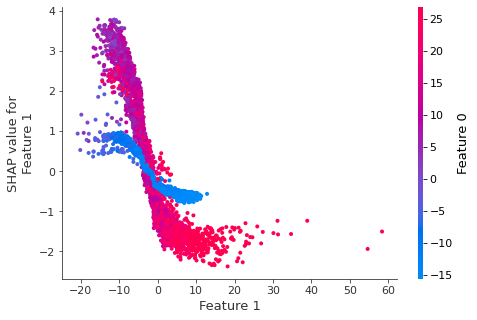

In [45]:
shap.dependence_plot(1, shap_values[1], X_train_pca)

Так можем посмотреть, как некоторые фичи зависят друг от друга

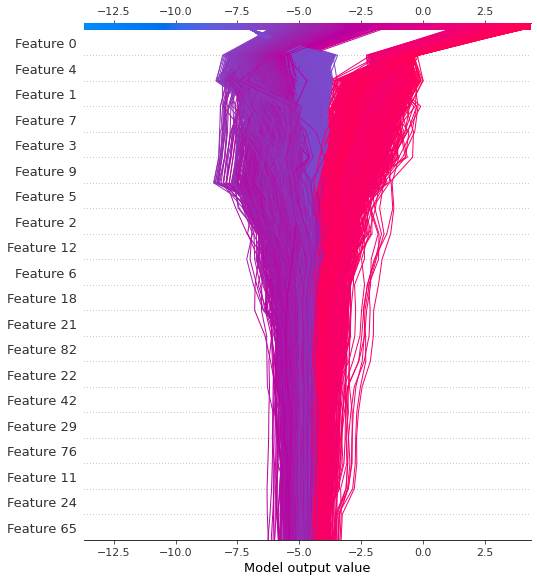

In [67]:
shap.decision_plot(explainer.expected_value[0], shap_values[0], X_train_pca, ignore_warnings=True)

А так можно посмотреть, как наше сложное дерево приходит к своему решению. У нас очень много разных фичей, поэтому получается не очень наглядно, но общий смысл понятен.

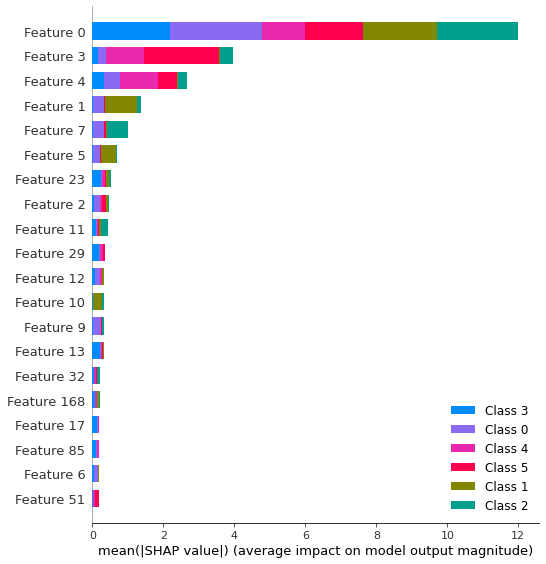

In [40]:
shap.summary_plot(shap_values, X_train_pca, plot_type="bar")

Показанная важность фичей совпадает с той, что мы получили с помощью lightgbm.plot_importance, но здесь наглядней виден вклад в каждый класс.

**Вывод:** shap - удобная библиотека для анализа поведения модели, которую можно использовать независимо от того, какую модель мы выбрали.